In [1]:
#%reload_ext autoreload
#%autoreload 2
import logging
log = lambda msg: logging.info(msg)
import os
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# Inspect why some EEG files are 'steppy'
Currently I know:
* The FIF data itself, that all the calculations are based on, is fine.
* The steppiness is introduced when writing the EDF file - probably because EDF is 16-bit and tries to scale data into that range.  I probably need to move to FIF or GDF, or figuring out https://www.edfplus.info/specs/edffloat.html.
* Since it's only affecting how the data is presented in the epoch viewer, it's not a priority.

In [2]:
input_dir = "C:\\dev\\play\\brainwave-data"


In [3]:
known_steppy = ['2024-12-19-21-18-48', '2024-11-25-21-27-21', '2024-09-03-21-10-58']
known_not_steppy = ['2024-09-08-21-01-39', '2024-09-01-21-11-15', '2024-12-14-21-26-54']

In [7]:
import contextlib
import os
import io
from importlib import reload
import convert
reload(convert)
from convert import load_mne_file, save_mne_as_edf
import numpy as np
import pandas as pd

def process_steppiness(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):
        input_file = os.path.join(root, dir_name, "raw.fif")
        if not os.path.exists(input_file):
            return None
        raw, input_file_without_ext, mne_filtered = load_mne_file(log, input_file)
        #save_mne_as_edf(print,  mne_filtered, input_file_without_ext)
        data = mne_filtered.get_data(units=dict(eeg="uV"))
        yasa = pd.read_csv(os.path.join(root, dir_name, "raw.yasa.csv"))
        # Want a good non-chaotic epoch
        first = yasa[(yasa['Stage'] == 'N3') & (yasa['Confidence'] > 0.8)].index[0]
        epoch_data = data[:, first * 7500: (first + 1) * 7500]
        num_unique = len(np.unique(epoch_data))
        unique_ratio = num_unique / len(epoch_data)
        abs_mean_distance = np.mean(np.abs(np.diff(epoch_data, axis=1)))
        return unique_ratio, first, abs_mean_distance

# Testing
for dir_name in known_steppy[:1]:
    steppiness, first, abs_mean_distance = process_steppiness(input_dir, dir_name, False)
    display("Steppy: ", dir_name, steppiness, first, abs_mean_distance)
# for dir_name in known_not_steppy[-1:]:
#     steppiness, first, abs_mean_distance = process_steppiness("C:\\dev\\play\\brainwave-data", dir_name, False)
#     display("Not-steppy: ", dir_name, steppiness, first, abs_mean_distance)


2025-01-10 07:46:31,212 - INFO - Reading file C:\dev\play\brainwave-data\2024-12-19-21-18-48\raw.fif
2025-01-10 07:46:31,854 - INFO - Finished reading file C:\dev\play\brainwave-data\2024-12-19-21-18-48\raw.fif

KeyboardInterrupt



In [8]:
input_file = os.path.join(input_dir, known_steppy[0], "raw.fif")
raw, input_file_without_ext, mne_filtered = load_mne_file(log, input_file)


2025-01-10 07:52:59,654 - INFO - Reading file C:\dev\play\brainwave-data\2024-12-19-21-18-48\raw.fif


Opening raw data file C:\dev\play\brainwave-data\2024-12-19-21-18-48\raw.fif...
Isotrak not found
    Range : 0 ... 7892024 =      0.000 ... 31568.096 secs
Ready.
Reading 0 ... 7892024  =      0.000 ... 31568.096 secs...


2025-01-10 07:53:00,678 - INFO - Finished reading file C:\dev\play\brainwave-data\2024-12-19-21-18-48\raw.fif


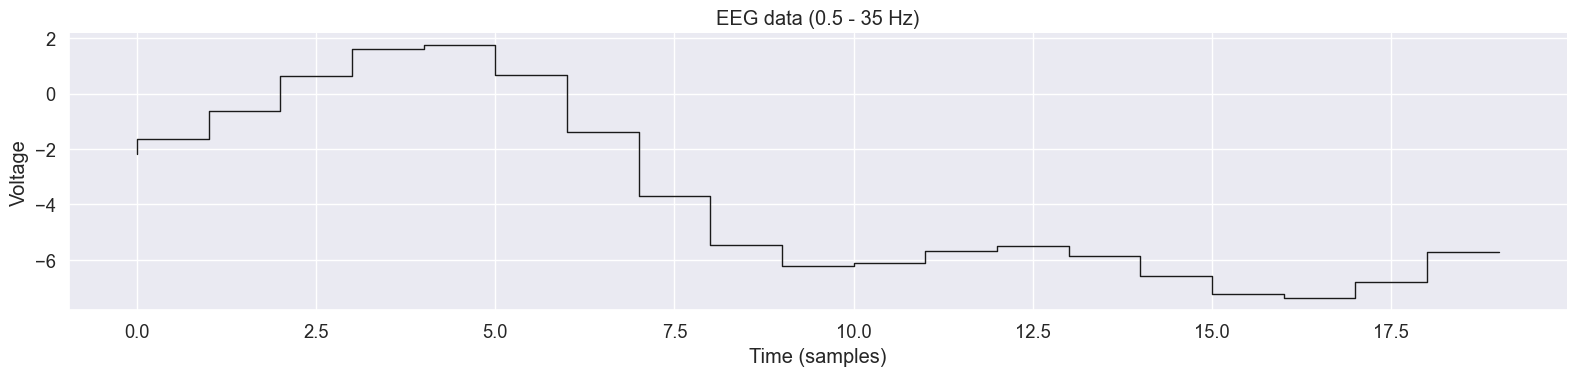

In [38]:
import notebooks.Util.DrawEpochs
reload(notebooks.Util.DrawEpochs)
from notebooks.Util.DrawEpochs import plot_eeg_epoch

epoch_data = notebooks.Util.DrawEpochs.get_epoch(mne_filtered, 279)[:20]
notebooks.Util.DrawEpochs.plot_eeg_data(epoch_data)

In [20]:
epoch_data

array([-2.19477983, -1.62307309, -0.63709401,  0.61893543,  1.62322596,
        1.74721904,  0.66450172, -1.38820471, -3.6967371 , -5.45900928,
       -6.22825565, -6.12449441, -5.69211237, -5.51897714, -5.87543688,
       -6.5954551 , -7.23405168, -7.3649081 , -6.81500838, -5.71618389])

In [ ]:

edf_file_path = os.path.join(input_dir, known_steppy[0], "raw.test_filtered4.edf")
# save_mne_as_edf(print,  raw, input_file_without_ext + ".test_raw.edf")
mne.export.export_raw(edf_file_path, mne_filtered, overwrite=True)

Overwriting existing file.


C:\Users\graha\AppData\Local\Temp\ipykernel_22056\2543278979.py:4: RuntimeWarning: EDF format requires equal-length data blocks, so 0.9 seconds of edge values were appended to all channels when writing the final block.
  mne.export.export_raw(edf_file_path, mne_filtered, overwrite=True)


In [62]:
sfreq

NameError: name 'sfreq' is not defined

In [64]:
import pyedflib
import numpy as np

def save_mne_as_edf_with_pyedflib(mne_raw, edf_file_path):
    data = mne_raw.get_data(units=dict(eeg="uV"))
    n_channels = data.shape[0]
    sfreq = int(mne_raw.info['sfreq'])
    channel_names = mne_raw.info['ch_names']

    file = pyedflib.EdfWriter(edf_file_path, n_channels, file_type=pyedflib.FILETYPE_EDFPLUS)

    channel_info = []
    for ch in channel_names:
        channel_info.append({
            'label': ch,
            'dimension': 'uV',
            'sample_rate': sfreq,
            'physical_min': -100000,
            'physical_max': 100000,
            'digital_min': -32768,
            'digital_max': 32767,
            'transducer': '',
            'prefilter': ''
        })

    file.setSignalHeaders(channel_info)
    file.writeSamples(data)
    file.close()

# Usage
edf_file_path = os.path.join(input_dir, known_steppy[0], "raw.test_filtered4.edf")

save_mne_as_edf_with_pyedflib(mne_filtered, edf_file_path)
#reread_edf = mne.io.read_raw_edf(edf_file_path, preload=True)

KeyboardInterrupt: 

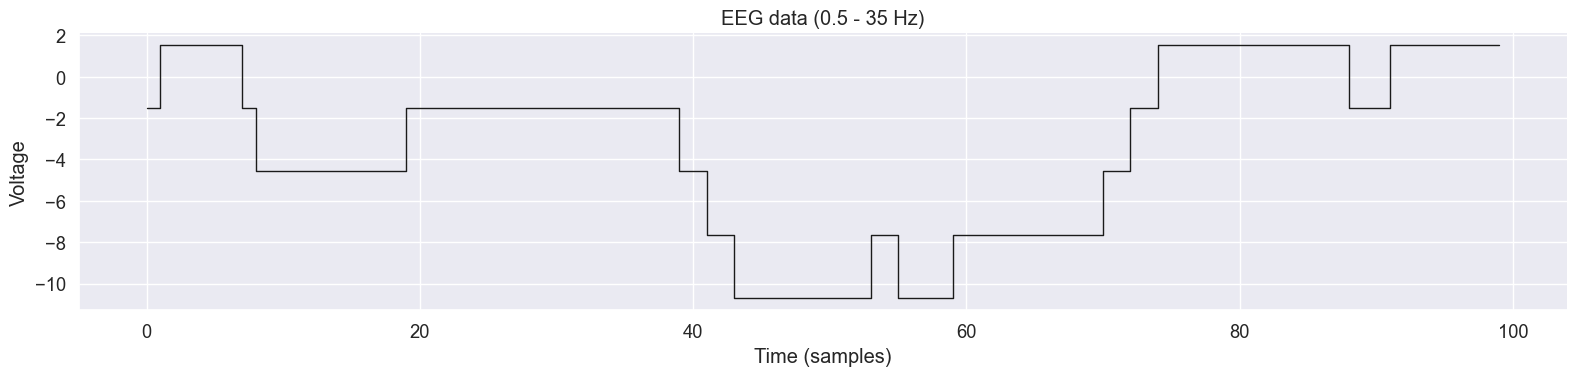

In [50]:
import notebooks.Util.DrawEpochs
reload(notebooks.Util.DrawEpochs)

reread_edf = mne.io.read_raw_edf(edf_file_path, preload=True)

epoch_data_edf = notebooks.Util.DrawEpochs.get_epoch(reread_edf, 279)[:100]
notebooks.Util.DrawEpochs.plot_eeg_data(epoch_data_edf)

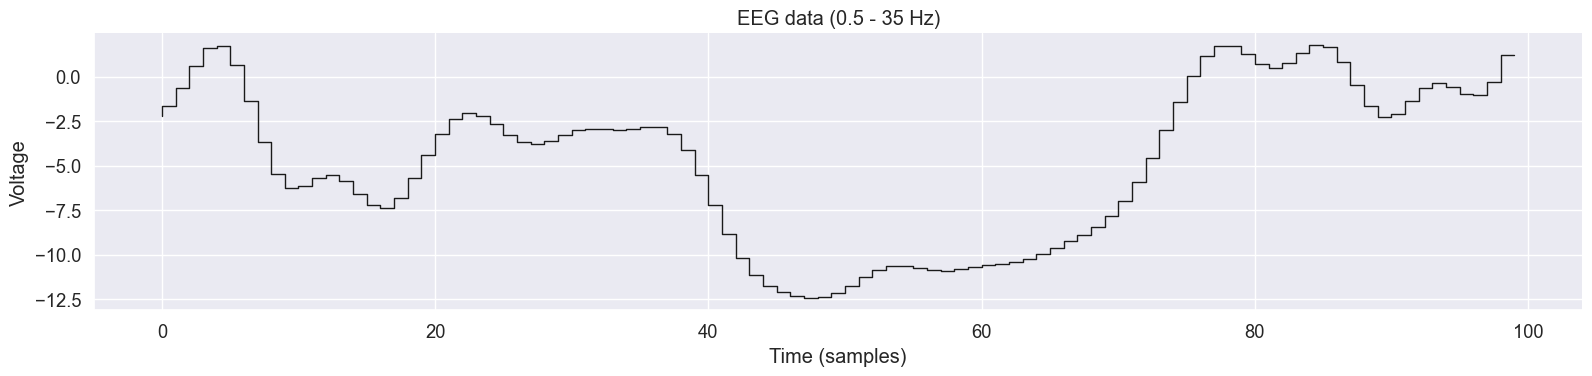

In [51]:
import notebooks.Util.DrawEpochs
reload(notebooks.Util.DrawEpochs)
from notebooks.Util.DrawEpochs import plot_eeg_epoch

epoch_data = notebooks.Util.DrawEpochs.get_epoch(mne_filtered, 279)[:100]
notebooks.Util.DrawEpochs.plot_eeg_data(epoch_data)

In [10]:
from tqdm.auto import tqdm
import pandas as pd

results = pd.DataFrame(columns=['dir_name', 'unique_ratio'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs)):
    # print(dir_name)
    unique_ratio = process_steppiness(input_dir, dir_name)
    results.loc[len(results)] = [dir_name, unique_ratio]

results

  0%|          | 0/125 [00:00<?, ?it/s]

2025-01-09 09:14:52,702 - INFO - Reading file C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.fif
2025-01-09 09:14:52,998 - INFO - Finished reading file C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.fif
C:\Users\graha\AppData\Local\Temp\ipykernel_44024\189623836.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results.loc[len(results)] = [dir_name, unique_ratio]
2025-01-09 09:14:53,969 - INFO - Reading file C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.fif
2025-01-09 09:14:54,967 - INFO - Finished reading file C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.fif
2025-01-09 09:14:57,069 - INFO - Reading file C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.fif
2025-01-09 09:14:58,046 - INFO - Finished reading file C:\dev

,dir_name,unique_ratio
0,08-07-2024--22-51-16,NaN
1,09-07-2024--22-52-25,NaN
2,2024-07-08-22-51-16,1046394.0
3,2024-07-11-22-46-18,1046394.0
4,2024-07-12-22-38-58,1046394.0
...,...,...
120,2025-01-06-21-35-21,1046394.0
121,2025-01-07-21-12-58,1046394.0
122,2025-01-08-21-41-09,1046394.0
123,compressed_files,NaN


In [2]:
import pandas as pd

input_file = "C:\\dev\\play\\brainwave-data\\2024-12-09-21-29-08\\raw.fif"

input_file_without_ext = os.path.splitext(input_file)[0]
input_dir = "C:\\dev\\play\\brainwave-data"


In [3]:
from convert import load_mne_file
raw, input_file_without_ext, mne_filtered = load_mne_file(log, input_file)

2025-01-09 09:11:02,415 - INFO - Reading file C:\dev\play\brainwave-data\2024-12-09-21-29-08\raw.fif


Opening raw data file C:\dev\play\brainwave-data\2024-12-09-21-29-08\raw.fif...
Isotrak not found
    Range : 0 ... 9281681 =      0.000 ... 37126.724 secs
Ready.
Reading 0 ... 9281681  =      0.000 ... 37126.724 secs...


2025-01-09 09:11:03,450 - INFO - Finished reading file C:\dev\play\brainwave-data\2024-12-09-21-29-08\raw.fif


In [4]:
data = raw.get_data(units=dict(eeg="uV"))

In [5]:
import numpy as np
num_unique = len(np.unique(data))
unique_ratio = num_unique / len(data)
unique_ratio

1046394.0